In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm
from IPython.core.display import HTML
from stargazer.stargazer import Stargazer
import statsmodels.nonparametric.kernel_regression as loess

from mizani.transforms import log_trans
from mizani.formatters import percent_format
from mizani.formatters import log_format

# 1.1.: Cleaning the dataframe

## Merge

In [2]:
# Read the CSVs into a variable
price_data = pd.read_csv('hotels-europe_price.csv')
features_data = pd.read_csv('hotels-europe_features.csv')

In [3]:
# merge the two datasets with the key 'hotel_id'
merged_hotel_data = pd.merge(price_data, features_data, on='hotel_id')

In [4]:
# filter the merged data for Moscow
merged_hotel_data_moscow = merged_hotel_data.loc[(merged_hotel_data["city_actual"] == "Moscow") &
                                                 (merged_hotel_data["accommodation_type"] == "Hotel") &
                                                 (merged_hotel_data["year"] == 2017) &
                                                 (merged_hotel_data["month"] == 12) &
                                                 (merged_hotel_data["weekend"] == 0) &
                                                 (merged_hotel_data["price"] < 500)]

## Ratings Data Cleaning

In [5]:
# Step 1: Identify the number of null values in the 'rating' column
null_count = merged_hotel_data_moscow['rating'].isnull().sum()
print(f"Number of null values in the 'rating' column: {null_count}")

Number of null values in the 'rating' column: 63


In [6]:
# Step 2: Transform null values to 0
merged_hotel_data_moscow['rating'].fillna('NULL', inplace=True)

C:\Users\iandr\AppData\Local\Temp\ipykernel_48980\2179072277.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'NULL' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
C:\Users\iandr\AppData\Local\Temp\ipykernel_48980\2179072277.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
# Optionally, verify the transformation
print(merged_hotel_data_moscow['rating'].isnull().sum())  # Should output 0

0


In [8]:
# Drop rows where 'rating' is 'NULL'
merged_hotel_data_moscow = merged_hotel_data_moscow[merged_hotel_data_moscow['rating'] != 'NULL']

# Optionally, verify the operation
print(f"Number of rows with 'rating' as 'NULL': {len(merged_hotel_data_moscow[merged_hotel_data_moscow['rating'] == 'NULL'])}")

Number of rows with 'rating' as 'NULL': 0


## `rating_reviewcount` cleaning

In [9]:
# Step 1: Identify the number of null values in the 'rating' column
null_count = merged_hotel_data_moscow['rating_reviewcount'].isnull().sum()
print(f"Number of null values in the 'rating' column: {null_count}")

Number of null values in the 'rating' column: 0


In [10]:
# Step 2: Transform null values to 0
merged_hotel_data_moscow['rating_reviewcount'].fillna('NULL', inplace=True)

In [11]:
# Optionally, verify the transformation
print(merged_hotel_data_moscow['rating_reviewcount'].isnull().sum())  # Should output 0

0


In [12]:
# Drop rows where 'rating_reviewcount' is 'NULL'
merged_hotel_data_moscow = merged_hotel_data_moscow[merged_hotel_data_moscow['rating_reviewcount'] != 'NULL']

# Optionally, verify the operation
print(f"Number of rows with 'rating_reviewcount' as 'NULL': {len(merged_hotel_data_moscow[merged_hotel_data_moscow['rating_reviewcount'] == 'NULL'])}")

Number of rows with 'rating_reviewcount' as 'NULL': 0


## Create `highly_rated` column

In [13]:
# new column 'highly_rated'
# Set to 1 if 'rating' is greater than or equal to 4, and 0 otherwise
merged_hotel_data_moscow['highly_rated'] = merged_hotel_data_moscow['rating'].apply(lambda x: 1 if x >= 4 else 0)
merged_hotel_data_moscow.head()

,hotel_id,price,offer,offer_cat,year,month,weekend,holiday,nnights,scarce_room,...,city_actual,rating_reviewcount,center1label,center2label,neighbourhood,ratingta,ratingta_count,distance_alter,accommodation_type,highly_rated
77578,10947,59,1,15-50% offer,2017,12,0,1,1,0,...,Moscow,240.0,City centre,Solntsevo Exhibition Hall,Alexeevsky,3.0,2351.0,15.0,Hotel,0
77581,10947,231,1,15-50% offer,2017,12,0,1,4,0,...,Moscow,240.0,City centre,Solntsevo Exhibition Hall,Alexeevsky,3.0,2351.0,15.0,Hotel,0
77590,10948,43,1,15-50% offer,2017,12,0,1,1,0,...,Moscow,19.0,City centre,Solntsevo Exhibition Hall,Alexeevsky,4.0,34.0,15.0,Hotel,0
77593,10948,168,1,15-50% offer,2017,12,0,1,4,0,...,Moscow,19.0,City centre,Solntsevo Exhibition Hall,Alexeevsky,4.0,34.0,15.0,Hotel,0
77598,10949,81,1,15-50% offer,2017,12,0,1,1,0,...,Moscow,31.0,City centre,Solntsevo Exhibition Hall,Alexeevsky,4.0,90.0,15.0,Hotel,0


# 1.2: Basic Attributes

In [14]:
merged_hotel_data_moscow[["stars","distance","price","highly_rated"]].describe().round(2)

,stars,distance,price,highly_rated
count,430.00,430.00,430.00,430.00
mean,3.32,3.60,173.27,0.67
std,0.83,3.51,126.07,0.47
min,1.00,0.00,21.00,0.00
25%,3.00,1.30,67.00,0.00
50%,3.00,2.20,127.50,1.00
75%,4.00,4.70,254.75,1.00
max,5.00,17.00,495.00,1.00


## Basic OLS Regression

In [15]:
# Assuming 'merged_hotel_data' is your DataFrame
# Selecting some potential independent variables (adjust as needed)
X = merged_hotel_data_moscow[['price', 'stars', 'distance']]  # Example features
y = merged_hotel_data_moscow['highly_rated']  # Dependent variable

# Adding a constant to the model (intercept)
X = sm.add_constant(X)

# Building the OLS model
model = sm.OLS(y, X).fit()

# Printing the summary of the model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           highly_rated   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     20.73
Date:                Wed, 06 Dec 2023   Prob (F-statistic):           1.48e-12
Time:                        14:34:04   Log-Likelihood:                -254.90
No. Observations:                 430   AIC:                             517.8
Df Residuals:                     426   BIC:                             534.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.091      0.008      0.9

### Basic OSL Interpretation
In this regression model, price, stars, and distance are tested for their potential correlations with the highly_rated variable. 

The `price` variable has a positive coefficient and a statistically significant p-value of 0.015. This suggests that the data provides evidence in support of the claim that an increase in price correlates with an increase in the likelihood of a hotel being classified as highly-rated. 

The `stars` variable has a positive coefficient and a statistically significant p-value below 0.01. This suggests that the data provides evidence in support of the claim that an increase in the number of stars a hotel has correlates with an increase in the liklihood of a hotel being classified as highly-rated. 

The `distance` variable has a positive coefficient, but does not have a statistically significant p-value below the 5% threshold. This suggests that the data does not provide eveidence in support of the claim that distance correlates with the `highly-rated` variable. 

The R-Squared of 12.7% suggests that this model is not the best fit for the `highly_rated` variable.

# Part 2

### **Estimate with distance and stars as explanatory variables**:
- linear probability models
- logit models
- probit models

*You may add other variables if you wish*.

### **Compare**:
- Coefficients
- Marginal differences
- Predicted probabilities

Discuss your results!

## Linear Probability Models

In [16]:
lpm1 = smf.ols(
    "highly_rated ~ np.log(price) + stars + distance",
    data = merged_hotel_data_moscow,
).fit(covtype="HC1")

In [17]:
stargazer = Stargazer([lpm1])
stargazer.covariate_order(
    [
        "np.log(price)",
        "stars",
        "distance",
        "Intercept"
    ]
)
stargazer.rename_covariates({"Intercept": "Constant",
                             "np.log(price)" : "lnPrice"})
stargazer.add_line("Offer indicators", ["Yes"])
stargazer


### LPM Interpretation

The `lnprice` variable is statistically significant at the 5% threshold, and has a positive coefficient. This suggests that an increase in `lnprice` could reflect on an increase in the probability a hotel is listed as highly rated; however, with such a small coefficient, this suggests that price changes have a small influence on the probability of a hotel being listed as highly rated. 

The `stars` variable is statistically significant at the 1% threshold, and has a positive coefficient. This suggests that an increase in the number of `stars` could reflect on  an increase in the probability a hotel is listed as highly rated.

The `distance` variable is statistically significant at the 10% threshold, which is too high for this research project. So, this will be interpretaed as not statistically significant. This suggests that `distance` is not a good measure of predicting the probability of if a hotel will be highly rated or not. 

With an R-squared of 12.7%, this suggests that this model has predictive capabilities, but there is a chance that there are other variables that influence the probability of a hotel being highly rated or not. 

In [18]:
merged_hotel_data_moscow["pred_lpm"] = lpm1.predict()
merged_hotel_data_moscow["pred_lpm"].describe().round(4)

count    430.0000
mean       0.6744
std        0.1694
min        0.1574
25%        0.5546
50%        0.6655
75%        0.7964
max        1.1897
Name: pred_lpm, dtype: float64

C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_bin : Removed 15 rows containing non-finite values.
C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.


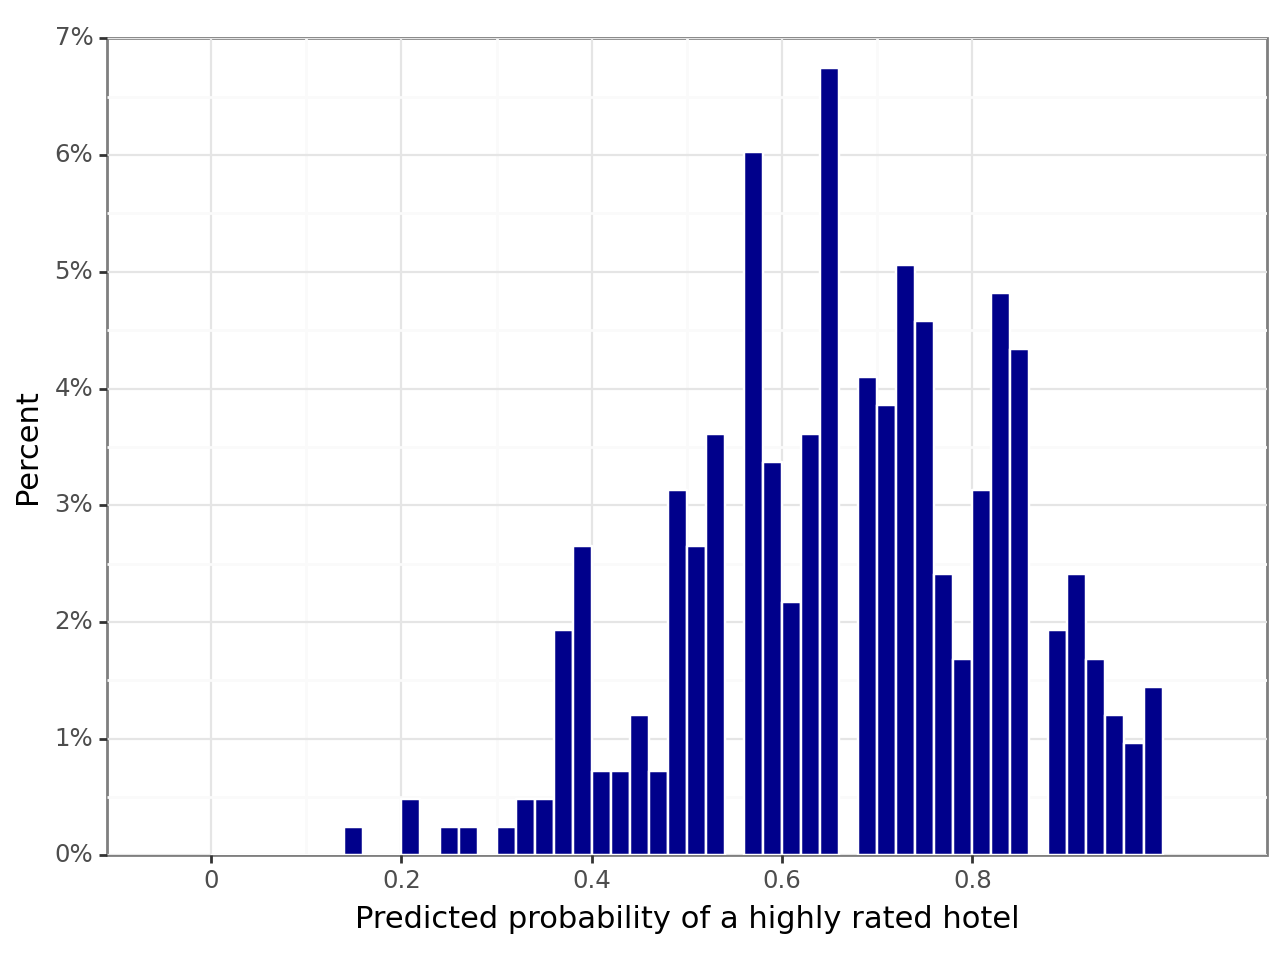

<Figure Size: (640 x 480)>

In [19]:
g1 = (
    ggplot(merged_hotel_data_moscow, aes(x="pred_lpm"))
    + geom_histogram(
        aes(y="stat(count)/sum(stat(count))"),
        binwidth=0.02,
        center=0.65,
        color="white",
        fill="darkblue",
        closed="right",
    )
    + labs(x="Predicted probability of a highly rated hotel", y="Percent")
    + scale_y_continuous(
        expand=[0.00, 0.0],
        limits=[0, 0.07],
        breaks=np.arange(0, 0.07, 0.01),
        labels=percent_format(),
    )
    + scale_x_continuous(expand=[0.1, 0.01], limits=[0, 1], breaks=np.arange(0, 1, 0.2))
    + theme_bw()
)
g1


### Histogram interpretation

This histogram seems to be normally distributed, with a mean around the 0.6-0.7 range. This suggests that there is a 60-70% probability of predicting if a hotel is highly rated or not. As the range of this histogram is between around 0.2 and 0.9, this model could be split into two sets: hotels that have a high probability of being predicted for being highly rated, and hotels that have a low probability of being predicted for being highly rated. 

In [20]:
cuts = 100
merged_hotel_data_moscow["q100_pred_lpm"] = pd.qcut(merged_hotel_data_moscow["pred_lpm"], q=cuts, labels=range(1, cuts + 1))

merged_hotel_data_moscow.loc[
    merged_hotel_data_moscow["q100_pred_lpm"] == 1,
    [
        "price",
        "stars",
        "distance"
    ],
].describe().round(1)

# Bottom 1%

,price,stars,distance
count,5.0,5.0,5.0
mean,67.0,1.0,2.4
std,40.8,0.0,2.5
min,35.0,1.0,0.5
25%,49.0,1.0,0.5
50%,51.0,1.0,1.0
75%,62.0,1.0,3.6
max,138.0,1.0,6.3


In [21]:
merged_hotel_data_moscow.loc[
    merged_hotel_data_moscow["q100_pred_lpm"] == 100,
    [
        "price",
        "stars",
        "distance"
    ],
].describe().round(1)

# Top 1%

,price,stars,distance
count,5.0,5.0,5.0
mean,384.8,4.8,10.4
std,150.8,0.4,7.7
min,118.0,4.0,1.6
25%,426.0,5.0,2.3
50%,446.0,5.0,16.0
75%,447.0,5.0,16.0
max,487.0,5.0,16.0


### Interpretation

Hotels in the bottom 1% of having the liklihood of being highly rated seem to have very low prices overall, especailly with the maximum price being 138. This is close to the minimum of the top 1% being 118. Additionally, the mean is very low compared to the mean of the top 1%. This suggests that low priced hotels are not likely to be highly rated, while hotels with higher prices have a high likelihood of being predicted as being highly rated. 

The stars are all 1, suggesting that hotels with low star counts are not likely to be highly rated. Compared to the top 1%, which only has 4 and 5 stars. This would suggests that hotels with high star counts are likely to be predicted as being highly rated. 

The distances for the bottom 1% seem to be much lower than the distances for the top 1%. The minimum for the top 1% overlaps with the mean of the bottom 1% distance. This suggests that it may be difficult to draw conclusions on the influence of distances on the probability of a hotel being highly rated or not. 

## Logit and Probit Models

In [22]:
from patsy import dmatrices
y, X = dmatrices(
    "highly_rated ~ np.log(price) + stars + distance",
    merged_hotel_data_moscow,
)

logit = sm.GLM(y, X, family=sm.families.Binomial(link=sm.genmod.families.links.logit()))
logit = logit.fit()


C:\Users\iandr\anaconda3\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The logit link alias is deprecated. Use Logit instead. The logit link alias will be removed after the 0.15.0 release.


In [23]:
logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           highly_rated   No. Observations:                  430
Model:                            GLM   Df Residuals:                      426
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -241.11
Date:                Wed, 06 Dec 2023   Deviance:                       482.22
Time:                        14:34:15   Pearson chi2:                     428.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1311
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -4.1910      0.790     -5.303      0.000      -5.740      -2.642
np.log(price)     0.3865      0.146      2.644      0.008       0.100       0.673
stars             0.8837      0.159      5.548      0.000       0.571       1.196
distance          0.0639      0.036      1.793      0.073      -0.006       0.134
=================================================================================
"""

### GLM Interpretation

This GLM model provides further eveidence that stars and prices are significant predictors of a hotel being highly rated. 

The `log(price)` variable has a positive coefficient with a statistically significant p-value at the 1% threshold. This suggests that `log(price)` has a positive associaition with the odds of a hotel being highly rated. 

The `stars` variable has a positive coefficient with a statistically significant p-value at the 1% threshold. This suggests that `stars` has a positive associaation with the odds of a hotel being highly rated. 

The `distance` variable has a positive coefficient, but does not have a statistically significant p-value below the 5% threshold. This suggests that `distance` is not a good predictor of the odds of a hotel being highly rated. 

The R-Squared of this model is 13.1%, which is quite low. This indicates that there are other variables that may better determine the odds of a hotel being highly rated.

In [24]:
merged_hotel_data_moscow["pred_logit"] = logit.predict()
merged_hotel_data_moscow["pred_logit"].describe()

count    430.000000
mean       0.674419
std        0.172256
min        0.129951
25%        0.557306
50%        0.688376
75%        0.820852
max        0.973576
Name: pred_logit, dtype: float64

In [25]:
logit = sm.Logit(y, X)
logit_result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.560721
         Iterations 6


In [26]:
logit_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           highly_rated   No. Observations:                  430
Model:                          Logit   Df Residuals:                      426
Method:                           MLE   Df Model:                            3
Date:                Wed, 06 Dec 2023   Pseudo R-squ.:                  0.1114
Time:                        14:34:16   Log-Likelihood:                -241.11
converged:                       True   LL-Null:                       -271.33
Covariance Type:            nonrobust   LLR p-value:                 4.725e-13
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -4.1910      0.790     -5.303      0.000      -5.740      -2.642
np.log(price)     0.3865      0.146      2.644      0.008       0.100       0.673
stars             0.8837      0.159      5.548      0.000       0.571       1.196
distance          0.0639      0.036      1.793      0.073      -0.006       0.134
=================================================================================
"""

### Logit Regression Results Interpretation

Compared to other models in this project, this logit regression furthers the claim that price and stars have a positive associated with the odds of a hotel being highly rated or not. In this model, and increase in price or stars is associated with the odds of a hotel being highly rated. The `distance` variable is still not statistically significant, so the data does not provide eveidence in support of distance having an association with the odds of a hotel being highly rated or not. 

The R-squared is still quite low, and suggests that there are probably other variables that are associated with a hotel being highly rated and would explain it better. 

In [27]:
logit_margef_results = logit_result.get_margeff()
logit_margef_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:           highly_rated
Method:                          dydx
At:                           overall
=================================================================================
                   dy/dx    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
np.log(price)     0.0734      0.027      2.725      0.006       0.021       0.126
stars             0.1679      0.026      6.346      0.000       0.116       0.220
distance          0.0121      0.007      1.816      0.069      -0.001       0.025
=================================================================================
"""

### Logit Marginal Effects Interpretation

This model allows us to see the marginal changes in the predictor variables. This will help us describe the change in odds of a hotel being highly rated for one unit change in the predictor variables. The dy/dx represents this change.

`Log(price)`: a dy/dx of 0.0734 suggests that a 1% increase in price will increase the odds of a hotel being highly rated by 7.34%, ceteris paribus. The p-value is below the 1% threshold, which is statistically significant. 

`stars`: a dy/dx of 0.1679 suggests that an increase in stars by 1 will increases the odds of a hotel being highly rated by 16.79%, ceteris paribus. The p-value is below the 1% threshold, which is statistically significant. 

`distance`: a dy/dx of 0.0121 suggests that an increase in one unit of distance will increase the odds of a hotel being highly rated by 1.21%, ceteris paribus. The p-value is above the 5% threshold, which is not statistically significantly. 

From this information, it seems that `stars` and `log(price)` are the best predictors out of these three variables in predicting the odds of a hotel being highly rated. `Distance` has a much smaller and less certain impact on the odds of a hotel being highly rated. 

In [28]:
probit = sm.Probit(y, X)
probit_result = probit.fit()

Optimization terminated successfully.
         Current function value: 0.560633
         Iterations 5


In [29]:
probit_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:           highly_rated   No. Observations:                  430
Model:                         Probit   Df Residuals:                      426
Method:                           MLE   Df Model:                            3
Date:                Wed, 06 Dec 2023   Pseudo R-squ.:                  0.1115
Time:                        14:34:16   Log-Likelihood:                -241.07
converged:                       True   LL-Null:                       -271.33
Covariance Type:            nonrobust   LLR p-value:                 4.551e-13
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -2.4740      0.462     -5.356      0.000      -3.379      -1.569
np.log(price)     0.2303      0.088      2.628      0.009       0.059       0.402
stars             0.5275      0.090      5.831      0.000       0.350       0.705
distance          0.0328      0.020      1.664      0.096      -0.006       0.071
=================================================================================
"""

### Probit Regression Results

The probit regression model looks at the probability that a hotel is "highly_rated" based on the predictive variables. 

`log(price)`: this variable has a coefficient of 0.2303, indicating that an increase in `log(price)` is associated with an increase in the z-score by 0.2303 standard deviations. Additionally, with a p-value below the 1% threshold, this is statistically significant. This indicates that an increase in `log(price)` is associated with an increase in the probability of a hotel being highly rated. 

`stars`: this variable has a coefficient of 0.5275, indicating that an increase in `stars` is associated with an increase in the z-score by 0.5275 standard deviations. Additionally, the p-value is below the 1% threshold, which is statistically significant. This indicates that an increase in `stars` is associated with an increase in the probability of a hotel being highly rated. 

`distance`: this variable has a coefficient of 0.0328, indicating that an increase in `distance` is associated with an increase in the z-score by 0.0328 standard deviations. This is quite a small amount, and with a p-value above the 5% threshold, this is not statistically significant. This indicates that a change in `distance` is not necessarily associated with a change in the probability of a hotel being highly rated. 

In [30]:
merged_hotel_data_moscow["pred_probit"] = probit_result.predict()
merged_hotel_data_moscow["pred_probit"].describe()

count    430.000000
mean       0.675236
std        0.170882
min        0.133200
25%        0.556709
50%        0.684207
75%        0.807929
max        0.981833
Name: pred_probit, dtype: float64

In [31]:
probit_margef_results = probit_result.get_margeff()
probit_margef_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
       Probit Marginal Effects       
=====================================
Dep. Variable:           highly_rated
Method:                          dydx
At:                           overall
=================================================================================
                   dy/dx    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
np.log(price)     0.0732      0.027      2.689      0.007       0.020       0.127
stars             0.1676      0.025      6.586      0.000       0.118       0.218
distance          0.0104      0.006      1.674      0.094      -0.002       0.023
=================================================================================
"""

### Probit Marginal Effects Interpretation

`log(price)`: with a dy/dx of 0.0732, this suggests that for a 1% increase in `price`, the probability that a hotel is highly rated increases by 7.32%, ceteris paribus. This is a statistically significant association, with a p-value below the 1% threshold. 

`stars`: with a dy/dx of 0.1676, this suggests that for a 1 star increase in `stars`, the probability that a hotel is highly rated increases by 16.76%, ceteris paribus. This is a statistically significant association, with a p.value below the 1% threshold. 

`distance`: with a dy/dx of 0.0104, this suggests that for a 1 unit increase in `distance`, the probability that a hotel is highly rated increases by 1.04%, ceteris paribus. This is not statistically significant, with a p-value above the 5% threshold. 

In [32]:
df_plot = pd.melt(
    merged_hotel_data_moscow[["pred_lpm", "pred_logit", "pred_probit"]].rename(
        columns={"pred_logit": "Logit", "pred_probit": "Probit"}
    ),
    value_vars=["Logit", "Probit"],
    id_vars=["pred_lpm"],
).sort_values(by=["variable"], ascending=False)

C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 30 rows containing missing values.


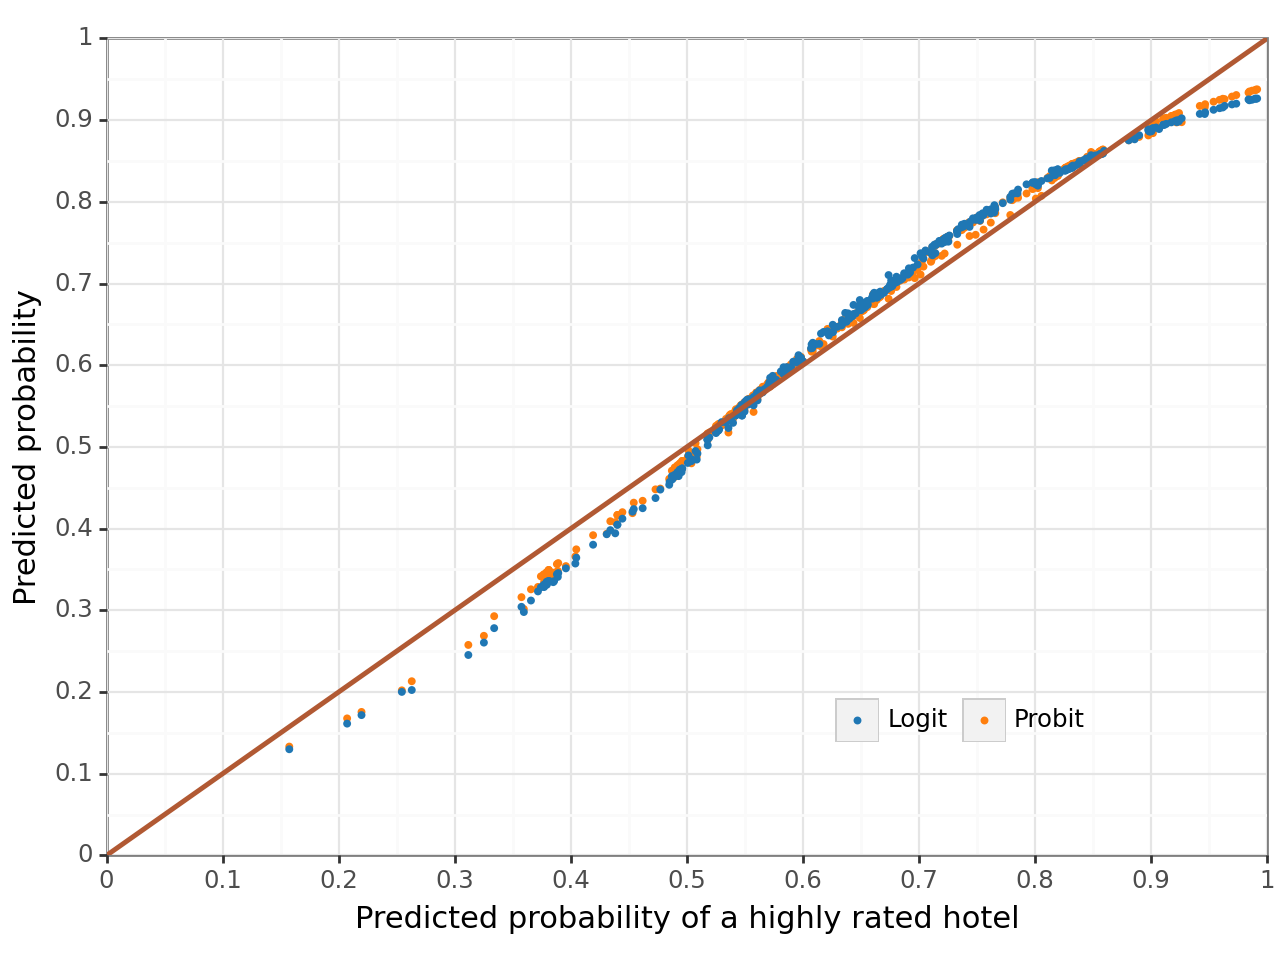

<Figure Size: (640 x 480)>

In [33]:
color = ["#1f77b4", "#ff7f0e", "#b15933"]

g2 = (
    ggplot(df_plot, aes(x="pred_lpm", y="value", color="variable"))
    + geom_point(size=0.6)
    + geom_abline(color=color[2], intercept=0, slope=1, size=1)
    + labs(
        x="Predicted probability of a highly rated hotel", y="Predicted probability"
    )
    + scale_y_continuous(expand=[0.00, 0.0], limits=[0, 1], breaks=np.arange(0, 1.1, 0.1))
    + scale_x_continuous(expand=[0.00, 0.0], limits=[0, 1], breaks=np.arange(0, 1.1, 0.1))
    + scale_color_manual(values=[color[0], color[1]])
    + theme_bw()
    + theme(
        legend_title=element_blank(),
        legend_direction="horizontal",
        legend_position=(0.75, 0.25),
        legend_background=element_blank(),
    )
)
g2